# Pneumonia Classification on X-rays images



### Importing Essentials

In [1]:
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.metrics import classification_report, confusion_matrix

2022-03-22 11:38:01.949151: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


### Import Datasets

In [2]:
import glob
main_path = "../input/chest-xray-pneumonia/chest_xray"

train_path = os.path.join(main_path, "train")
test_path = os.path.join(main_path, "test")

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")
test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")

val_path = os.path.join(main_path, 'val')
val_normal = glob.glob(val_path+"/NORMAL/*.jpeg")
val_pneumonia = glob.glob(val_path+"/PNEUMONIA/*.jpeg")

In [3]:
# train
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

# test
test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

# validation
val_list = [x for x in val_normal]
val_list.extend([x for x in val_pneumonia])

df_val = pd.DataFrame(np.concatenate([['Normal']*len(val_normal) , ['Pneumonia']*len(val_pneumonia)]), columns = ['class'])
df_val['image'] = [x for x in val_list]

In [4]:
df_train

,class,image
0,Normal,../input/chest-xray-pneumonia/chest_xray/train...
1,Normal,../input/chest-xray-pneumonia/chest_xray/train...
2,Normal,../input/chest-xray-pneumonia/chest_xray/train...
3,Normal,../input/chest-xray-pneumonia/chest_xray/train...
4,Normal,../input/chest-xray-pneumonia/chest_xray/train...
...,...,...
5211,Pneumonia,../input/chest-xray-pneumonia/chest_xray/train...
5212,Pneumonia,../input/chest-xray-pneumonia/chest_xray/train...
5213,Pneumonia,../input/chest-xray-pneumonia/chest_xray/train...
5214,Pneumonia,../input/chest-xray-pneumonia/chest_xray/train...


In [5]:
df_test

,class,image
0,Normal,../input/chest-xray-pneumonia/chest_xray/test/...
1,Normal,../input/chest-xray-pneumonia/chest_xray/test/...
2,Normal,../input/chest-xray-pneumonia/chest_xray/test/...
3,Normal,../input/chest-xray-pneumonia/chest_xray/test/...
4,Normal,../input/chest-xray-pneumonia/chest_xray/test/...
...,...,...
619,Pneumonia,../input/chest-xray-pneumonia/chest_xray/test/...
620,Pneumonia,../input/chest-xray-pneumonia/chest_xray/test/...
621,Pneumonia,../input/chest-xray-pneumonia/chest_xray/test/...
622,Pneumonia,../input/chest-xray-pneumonia/chest_xray/test/...


In [6]:
df_train.shape, df_test.shape, df_val.shape

((5216, 2), (624, 2), (16, 2))

# Exploratory Data Analysis

### Training set

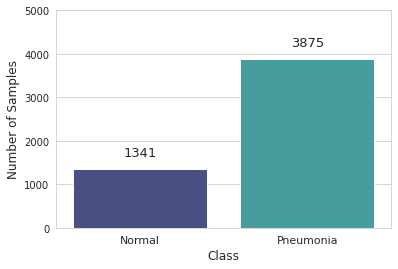

In [7]:
import seaborn as sns
sns.set_style('whitegrid')
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=df_train, palette="mako")

plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Samples",fontsize=12)
plt.ylim(0,5000)
plt.xticks([0,1],['Normal', 'Pneumonia'],fontsize=11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30,p.get_height()+300),fontsize=13)

plt.show()

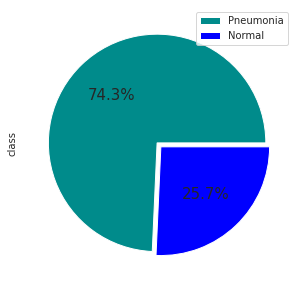

In [8]:
plt.figure(figsize=(7,5))

df_train['class'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', colors = ['darkcyan','blue'], explode = [0,0.05], textprops = {"fontsize":15})

plt.legend(labels=['Pneumonia', 'Normal'])
plt.show()

#### Testing set

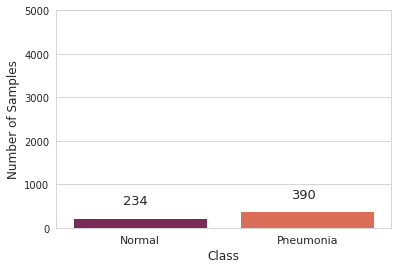

In [9]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=df_test, palette="rocket")

plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Samples",fontsize=12)
plt.ylim(0,5000)
plt.xticks([0,1],['Normal', 'Pneumonia'],fontsize=11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30,p.get_height()+300),fontsize=13)

plt.show()

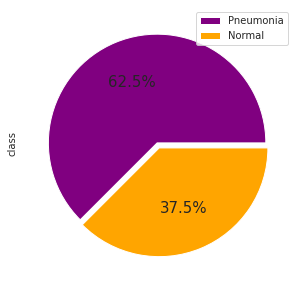

In [10]:
plt.figure(figsize=(7,5))

df_test['class'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', colors=['purple','orange'], explode = [0,0.05], textprops = {"fontsize":15})

plt.legend(labels=['Pneumonia', 'Normal'])
plt.show()

#### Validation set

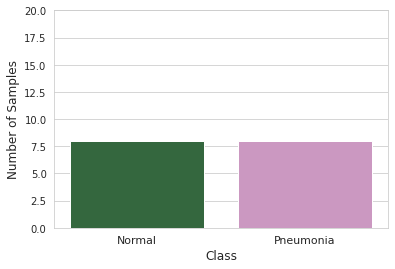

In [11]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=df_val, palette="cubehelix")

plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Samples",fontsize=12)
plt.ylim(0,20)
plt.xticks([0,1],['Normal', 'Pneumonia'],fontsize=11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30,p.get_height()+300),fontsize=13)

plt.show()

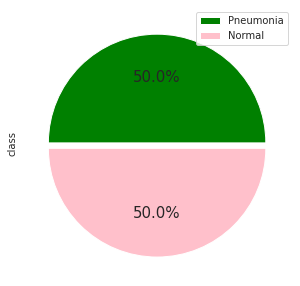

In [12]:
plt.figure(figsize=(7,5))

df_val['class'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', colors=['green','pink'], explode = [0,0.05], textprops = {"fontsize":15})

plt.legend(labels=['Pneumonia', 'Normal'])
plt.show()

The distributions from these datasets are a little different from each other. Both are slightly imbalanced, having more samples from the positive class (Pneumonia), with the training set being a little more imbalanced.

Before we move on to the next section, we will take a look at a few examples from each dataset.

Train Set - Normal


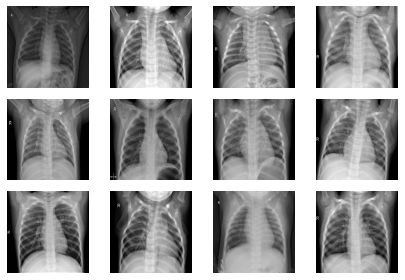

In [13]:
import cv2

print('Train Set - Normal')

for i in range(0,12):
#     plt.figure(figsize=(7,8))
    plt.subplot(3,4,i+1)
    img = cv2.imread(train_normal[i])
    img = cv2.resize(img,(224,224))
    plt.imshow(img)
    plt.axis('off')
    
plt.tight_layout()
plt.show()

Train Set - Pneumonia


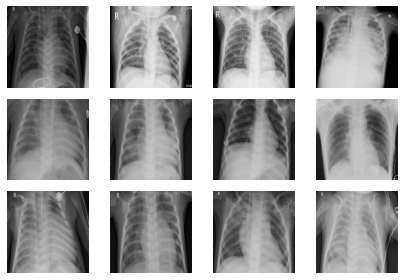

In [14]:
print('Train Set - Pneumonia')

for i in range(0,12):
#     plt.figure(figsize=(7,8))
    plt.subplot(3,4,i+1)
    img = cv2.imread(train_pneumonia[i])
    img = cv2.resize(img,(224,224))
    plt.imshow(img)
    plt.axis('off')
    
plt.tight_layout()
plt.show()

Now, we’re going to load the images from the folders and prepare them to feed our models.

We begin by defining the data generators. With Keras Image Data Generator, we can rescale the pixel values and apply random transformation techniques for data augmentation on the fly. We define two different generators. The val_datagen is used to simply rescale the validation and test sets. The train_datagen includes some transformations to augment the train set.

We apply those generators on each dataset using the flow_from_dataframe method. Apart from the transformations defined in each generator, the images are also resized based on the target_size set.

In [18]:
# Data Augmentation on train dataset
train_datagen = ImageDataGenerator(rescale=1/255.,
                                  zoom_range=0.1,
                                  rotation_range=0.1,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1)
# keeping validation data same and just rescaling it
val_datagen = ImageDataGenerator(rescale=1/255.)

train_imgGen = train_datagen.flow_from_dataframe(df_train,
                                             #directory=train_path, #dataframe contains the full paths
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (224, 224),
                                             class_mode = 'binary',
                                             batch_size = 32,
                                             seed = 42)

val_imgGen = val_datagen.flow_from_dataframe(df_val,
                                            #directory=train_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (224, 224),
                                            class_mode = 'binary',
                                            batch_size = 32,
                                            seed = 42)

test_imgGen = val_datagen.flow_from_dataframe(df_test,
                                            #directory=test_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (223, 223),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

Found 5216 validated image filenames belonging to 2 classes.
Found 16 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.
